In [2]:
%matplotlib inline
# IMPORTS
import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

TRAIN_DIR = "train"
TEST_DIR = "test"

call_set = set([])

In [3]:
# UTILITIES
# these are the fifteen malware classes we're looking for
malware_classes = ["Agent", "AutoRun", "FraudLoad", "FraudPack", "Hupigon", "Krap",
           "Lipler", "Magania", "None", "Poison", "Swizzor", "Tdss",
           "VB", "Virut", "Zbot"]

# a function for writing predictions in the required format
def write_predictions(predictions, ids, outfile):
    """
    assumes len(predictions) == len(ids), and that predictions[i] is the
    index of the predicted class with the malware_classes list above for 
    the executable corresponding to ids[i].
    outfile will be overwritten
    """
    with open(outfile,"w+") as f:
        # write header
        f.write("Id,Prediction\n")
        for i, history_id in enumerate(ids):
            f.write("%s,%d\n" % (history_id, predictions[i]))

In [4]:
def add_to_set(tree):
    for el in tree.iter():
        call = el.tag
        call_set.add(call)

In [5]:
def create_data_matrix(start_index, end_index, direc="train"):
    X = None
    classes = []
    ids = [] 
    i = -1
    for datafile in os.listdir(direc):
        if datafile == '.DS_Store':
            continue

        i += 1
        if i < start_index:
            continue 
        if i >= end_index:
            break

        # extract id and true class (if available) from filename
        id_str, clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(malware_classes.index(clazz))

        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
            assert clazz == "X"
            classes.append(-1)

        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        add_to_set(tree)
        this_row = call_feats(tree)
        if X is None:
            X = this_row 
        else:
            X = np.vstack((X, this_row))

    return X, np.array(classes), ids

In [6]:
good_calls = [
    'processes', 'query_value', 'read_section', 'read_section_names', 'read_value', 
        'recv_socket', 'remove_directory', 'revert_to_self', 'send_socket', 
        'set_file_attributes', 'set_file_time', 'set_system_time', 'set_thread_context', 
        'set_value', 'set_windows_hook', 'show_window', 'sleep', 'start_service', 'thread',
        'trimmed_bytes', 'unload_driver', 'vm_allocate', 'vm_mapviewofsection', 'vm_protect',
        'vm_read', 'vm_write', 'write_value', 'open_key', 'create_open_file', 'get_host_by_name', 
        'load_dll', 'create_mutex', 'load_image', 'create_file', 'get_file_attributes', 'open_process',
        'find_window', 'com_create_instance', 'destroy_window', 'impersonate_user', 'dump_line']

In [7]:
def call_feats(tree):
    
#     bigram_calls = []
#     for a_call in good_calls:
#         for b_call in good_calls:
#             bigram_calls.append(a_call + '_' + b_call)
            
#     combined_calls = good_calls + bigram_calls

    call_counter = {}
    last_call='start'
    for el in tree.iter():
        call = el.tag
        # Add specific call counts
        if call not in call_counter:
            call_counter[call] = 1
        else:
            call_counter[call] += 1
            
#         # Bigram Calls
#         combo = last_call + '_' + call
#         if combo not in call_counter:
#             call_counter[combo] = 1
#         #else:
#         #    call_counter[combo] += 1
#         last_call = call
            
    call_feat_array = np.zeros(len(good_calls))
    for i in range(len(good_calls)):
        call = good_calls[i]
        call_feat_array[i] = 0
        if call in call_counter:
            call_feat_array[i] = call_counter[call]

    return call_feat_array

## Import the data

In [8]:
# TRAINING DATA
X_train, t_train, train_ids = create_data_matrix(0, 2777, TRAIN_DIR)
X_valid, t_valid, valid_ids = create_data_matrix(2777, 3086, TRAIN_DIR)
X_train_all, t_train_all, train_all_ids = create_data_matrix(0, 3086, TRAIN_DIR)

print 'Data matrix (training set):'
print X_train
print 'Classes (training set):'
print t_train

Data matrix (training set):
[[  1.00000000e+00   2.42000000e+02   0.00000000e+00 ...,   4.20000000e+01
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   2.00400000e+03   1.00000000e+00 ...,   6.50000000e+01
    1.20000000e+01   3.43400000e+03]
 [  1.00000000e+00   7.00000000e+00   0.00000000e+00 ...,   3.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  1.00000000e+00   5.34000000e+02   0.00000000e+00 ...,   0.00000000e+00
    3.00000000e+00   2.60000000e+01]
 [  1.00000000e+00   2.60000000e+02   0.00000000e+00 ...,   7.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   2.42000000e+02   0.00000000e+00 ...,   4.20000000e+01
    0.00000000e+00   0.00000000e+00]]
Classes (training set):
[ 8  6 12 ..., 10  8  8]


In [9]:
# TESTING DATA
X_test_all, t_test_all, test_all_ids = create_data_matrix(0, 3724, TEST_DIR)

## Exploratory Data Analysis

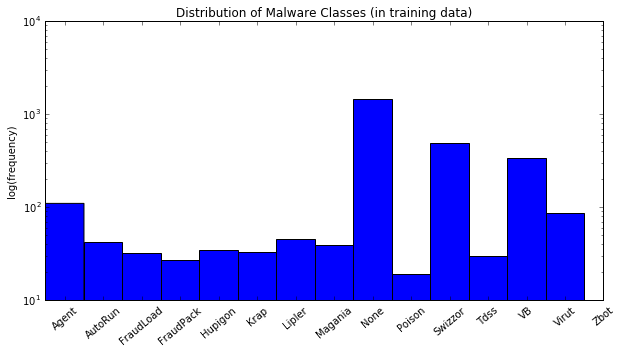

In [84]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.hist(t_train,bins = range(len(malware_classes)))
ax.set_xticklabels(malware_classes,rotation = 40)
ax.set_xticks(.5 + np.arange(len(malware_classes)))
ax.set_yscale('log')
ax.set_ylabel('log(frequency)')
plt.title('Distribution of Malware Classes (in training data)')
plt.show()

## Test the models

In [149]:
# Try SVM
clf = svm.SVC()
clf.fit(X_train, t_train)
print "SVM"
print "Score of validation set: %f" % clf.score(X_valid, t_valid)

SVM
Score of validation set: 0.770227


### Random Forests

In [174]:
# Random Forest Classifier
print "Random Forests"
ns = [1,5,7,8,9,10,11,12,13,14,15,20,25,30,35,40,50,100,200]
for n in ns:
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(X_train, t_train)
    print "For n = %d, score was: %f" % (n, rf.score(X_valid, t_valid))

Random Forests
For n = 1, score was: 0.864078
For n = 5, score was: 0.867314
For n = 7, score was: 0.889968
For n = 8, score was: 0.889968
For n = 9, score was: 0.889968
For n = 10, score was: 0.893204
For n = 11, score was: 0.893204
For n = 12, score was: 0.893204
For n = 13, score was: 0.909385
For n = 14, score was: 0.902913
For n = 15, score was: 0.906149
For n = 20, score was: 0.899676
For n = 25, score was: 0.912621
For n = 30, score was: 0.915858
For n = 35, score was: 0.902913
For n = 40, score was: 0.899676
For n = 50, score was: 0.909385
For n = 100, score was: 0.909385
For n = 200, score was: 0.902913


In [53]:
rf = RandomForestClassifier(n_estimators=30, min_samples_split=3)
rf.fit(X_train, t_train)
print "Score was: %f" % (rf.score(X_valid, t_valid))

Score was: 0.915858


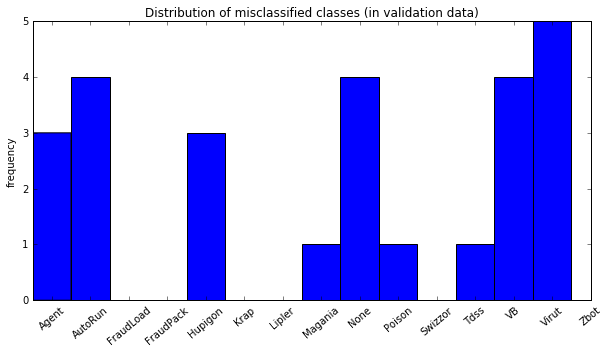

In [86]:
# take a look at the classes from which our misclassifieds came from
misclassified_indices = np.nonzero(1*(rf.predict(X_valid) != t_valid))[0]
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.hist(t_valid[misclassified_indices],bins = range(len(malware_classes)))
ax.set_xticklabels(malware_classes,rotation = 40)
ax.set_xticks(.5 + np.arange(len(malware_classes)))

ax.set_ylabel('frequency')
plt.title('Distribution of misclassified classes (in validation data)')
plt.show()

### KNC

In [171]:
# Try KNeighborsClassifier
ns = [1,2,3,4,5,6,7,8,10,20,25,30,50,100,200]
kneighborsscores = []
print "KNeighborsClassifier"
for n in ns:
    nn = KNeighborsClassifier(n_neighbors=n)
    nn.fit(X_train, t_train)
    score = nn.score(X_valid, t_valid)
    kneighborsscores.append(score)
    print "For n = %d, score was: %f" % (n, score)

KNeighborsClassifier
For n = 1, score was: 0.844660
For n = 2, score was: 0.844660
For n = 3, score was: 0.864078
For n = 4, score was: 0.864078
For n = 5, score was: 0.857605
For n = 6, score was: 0.864078
For n = 7, score was: 0.854369
For n = 8, score was: 0.857605
For n = 10, score was: 0.851133
For n = 20, score was: 0.844660
For n = 25, score was: 0.841424
For n = 30, score was: 0.831715
For n = 50, score was: 0.818770
For n = 100, score was: 0.773463
For n = 200, score was: 0.728155


In [84]:
kneighborsscores2 = []
nn = KNeighborsClassifier(n_neighbors=6, weights='distance')
nn.fit(X_train, t_train)
score = nn.score(X_valid, t_valid)
kneighborsscores2.append(score)
print "Score was: %f" % (score)

Score was: 0.883495


In [151]:
kneighborsscores2 = []
nn = KNeighborsClassifier(n_neighbors=6, weights='distance', p=1)
nn.fit(X_train, t_train)
score = nn.score(X_valid, t_valid)
kneighborsscores2.append(score)
print "Score was: %f" % (score)

Score was: 0.889968


## Generate Predictions

In [96]:
# Generate predictions on test set for the best model

nn = KNeighborsClassifier(n_neighbors=6, weights='distance', p=1)
nn.fit(X_train_all, t_train_all)
test_predictions = nn.predict(X_test_all)

In [184]:
rf = RandomForestClassifier(n_estimators=30, min_samples_split=3)
rf.fit(X_train_all, t_train_all)
test_predictions = rf.predict(X_test_all)

In [185]:
def write_to_file(filename, ids, predictions):
    zips = zip(ids, predictions)
    with open(filename, "w") as f:
        f.write("Id,Prediction\n")
        for i,p in enumerate(zips):
            f.write(str(p[0]) + "," + str(p[1]) + "\n")

In [186]:
write_to_file("prediction.csv", test_all_ids, test_predictions)

## Sandbox

In [48]:
# Run this to see what call_feats returns
direc = "train"
for idx, datafile in enumerate(os.listdir(direc)):
    if idx == 1:
        print datafile
        tree = ET.parse(os.path.join(direc,datafile))
        feats = call_feats(tree)
        
#         for el in tree.iter():
#             print el.tag
        print feats

00278ec420236020d6121dffe0cc20034422e7228.Lipler.xml
[  1.00000000e+00   2.00400000e+03   1.00000000e+00   0.00000000e+00
   5.10000000e+01   2.11000000e+02   1.00000000e+00   0.00000000e+00
   1.70000000e+01   2.00000000e+01   1.80000000e+01   0.00000000e+00
   0.00000000e+00   7.00000000e+01   2.80000000e+01   4.00000000e+00
   2.54000000e+02   0.00000000e+00   4.10000000e+01   2.05000000e+02
   0.00000000e+00   0.00000000e+00   0.00000000e+00   3.65000000e+02
   0.00000000e+00   0.00000000e+00   3.00000000e+00]
